In [1]:
import torch
import ST
from sklearn.model_selection import train_test_split
import torchmetrics
from torchsummary import summary

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device


device(type='cuda', index=0)

## Structures for segmentation

In [2]:
def show_answer (image, model):
    pred = model.Use(image.reshape((1, 3, 270, 480))).reshape(2, 270, 480).permute(1, 2, 0)
    answer = torch.zeros((1, 270, 480))

    for y, string in enumerate(pred):
        for x, el in enumerate(string):
            answer[0][y][x] = torch.argmax(el)

    ST.imshow(answer)
    return answer

In [3]:
def neg_log_iou (tensor1, tensor2):
    iou_loss = torchmetrics.classification.BinaryJaccardIndex().to(device)
    return (iou_loss(tensor1, tensor2).log()) * -1

In [4]:
class Down_Conv (torch.nn.Module):
    def __init__ (
        self,
        num_of_blocks,
        input_channels,
        output_channels,
        kernel_size = 3,
        last_kernel = 3,
        pooling_size = 2,
        last_padding = 1,
        padding = 1,
        dropout = 0.2,
    ):
        super().__init__()
        conv_blocks = []

        for current_block in range(num_of_blocks):
            conv_blocks.append(ST.Conv(
                input_channels = input_channels if current_block == 0 else output_channels,
                output_channels = output_channels,
                kernel_size = kernel_size if current_block != 0 else last_kernel,
                padding = padding if current_block != 0 else last_padding,
                dropout = dropout,
            ))

        conv_blocks.append(torch.nn.MaxPool2d(pooling_size))

        self.block = torch.nn.Sequential(*conv_blocks)

    def forward (self, x):
        return self.block(x)
        

In [5]:
class Unet (torch.nn.Module):
    def __init__(
        self,
        num_of_blocks = 3,
    ):
        super().__init__()

        self.d0 = ST.Conv(
            input_channels = 3,
            output_channels = 64,
            kernel_size = 1,
            padding = 0,
        )

        self.d1 = ST.Down_Conv(
            num_of_blocks = num_of_blocks,
            input_channels = 64,
            output_channels = 128,
            kernel_size = 3,
            padding = 1,
        )

        self.d2 = ST.Down_Conv(
            num_of_blocks = num_of_blocks,
            input_channels = 128,
            output_channels = 256,
            kernel_size = 3,
            padding = 1,
        )

        self.d3 = ST.Down_Conv(
            num_of_blocks = num_of_blocks,
            input_channels = 256,
            output_channels = 512,
            kernel_size = 3,
            padding = 1,
        )

        self.base = ST.Down_Conv(
            num_of_blocks = num_of_blocks,
            input_channels = 512,
            output_channels = 512,
            kernel_size = 5,
            padding = 2,
        )

        self.u1 = ST.Up_Conv(
            input_channels = 512,
            output_channels = 256,
            kernel_size = (2, 3),
            padding = 1,
            scale_factor = 2.,
        )

        self.u2 = ST.Up_Conv(
            input_channels = 768,
            output_channels = 256,
            kernel_size = (2,3),
            padding = 1,
            scale_factor = 2.,
        )

        self.u3 = ST.Up_Conv(
            input_channels = 512,
            output_channels = 128,
            kernel_size = (2, 3),
            padding = 1,
            scale_factor = 2.,
        )

        self.u4 = ST.Up_Conv(
            input_channels = 256,
            output_channels = 64,
            kernel_size = 3,
            padding = 1,
            scale_factor = 2.,
        )

        self.final_activation = torch.nn.Sigmoid()

        self.final_conv = torch.nn.Conv2d(
            in_channels = 128,
            out_channels = 2,
            kernel_size = 1,
            padding = 0,
        )

    def forward(self, tensor):
        d0 = self.d0(tensor)
        d1 = self.d1(d0)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        
        base = self.base(d3)
        
        u1 = torch.cat((
            self.u1(base),
            d3
        ), dim = 1)

        u2 = torch.cat((
            self.u2(u1),
            d2,
        ), dim = 1)

        u3 = torch.cat((
            self.u3(u2),
            d1,
        ), dim = 1)

        u4 = torch.cat((
            self.u4(u3),
            d0,
        ), dim = 1)

        final_conv = self.final_activation(self.final_conv(u4))
    
        return final_conv

In [6]:
model = Unet(num_of_blocks = 3)
summary(model, torch.zeros((1, 3, 270, 480)) )

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv: 1-1                              [-1, 64, 270, 480]        --
|    └─Sequential: 2-1                   [-1, 64, 270, 480]        --
|    |    └─Dropout: 3-1                 [-1, 3, 270, 480]         --
|    |    └─Conv2d: 3-2                  [-1, 64, 270, 480]        256
|    |    └─BatchNorm2d: 3-3             [-1, 64, 270, 480]        128
|    |    └─ReLU: 3-4                    [-1, 64, 270, 480]        --
├─Down_Conv: 1-2                         [-1, 128, 135, 240]       --
|    └─Sequential: 2-2                   [-1, 128, 135, 240]       --
|    |    └─Conv: 3-5                    [-1, 128, 270, 480]       74,112
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ReLU: 3-6                    [-1, 128, 270, 480]       --
├─Down_Conv: 1                           []                        --
|    └─Se

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv: 1-1                              [-1, 64, 270, 480]        --
|    └─Sequential: 2-1                   [-1, 64, 270, 480]        --
|    |    └─Dropout: 3-1                 [-1, 3, 270, 480]         --
|    |    └─Conv2d: 3-2                  [-1, 64, 270, 480]        256
|    |    └─BatchNorm2d: 3-3             [-1, 64, 270, 480]        128
|    |    └─ReLU: 3-4                    [-1, 64, 270, 480]        --
├─Down_Conv: 1-2                         [-1, 128, 135, 240]       --
|    └─Sequential: 2-2                   [-1, 128, 135, 240]       --
|    |    └─Conv: 3-5                    [-1, 128, 270, 480]       74,112
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ReLU: 3-6                    [-1, 128, 270, 480]       --
├─Down_Conv: 1                           []                        --
|    └─Se

## Getting dataset

In [7]:
train_images = torch.load("Saved Tensors/Augmented images.pth")
train_answers = torch.load("Saved Tensors/Segmentation answers.pth")
train_images.shape

torch.Size([1010, 3, 270, 480])

In [8]:
train_X = train_images[:950].to(device)
val_X = train_images[950:].to(device)
train_y = train_answers[:190].to(device = device)
val_y = train_answers[190:].to(device)

## Teaching model

In [9]:
model = Unet().to(device)

st_model = ST.Model_Using(model = model,
                          device = device)

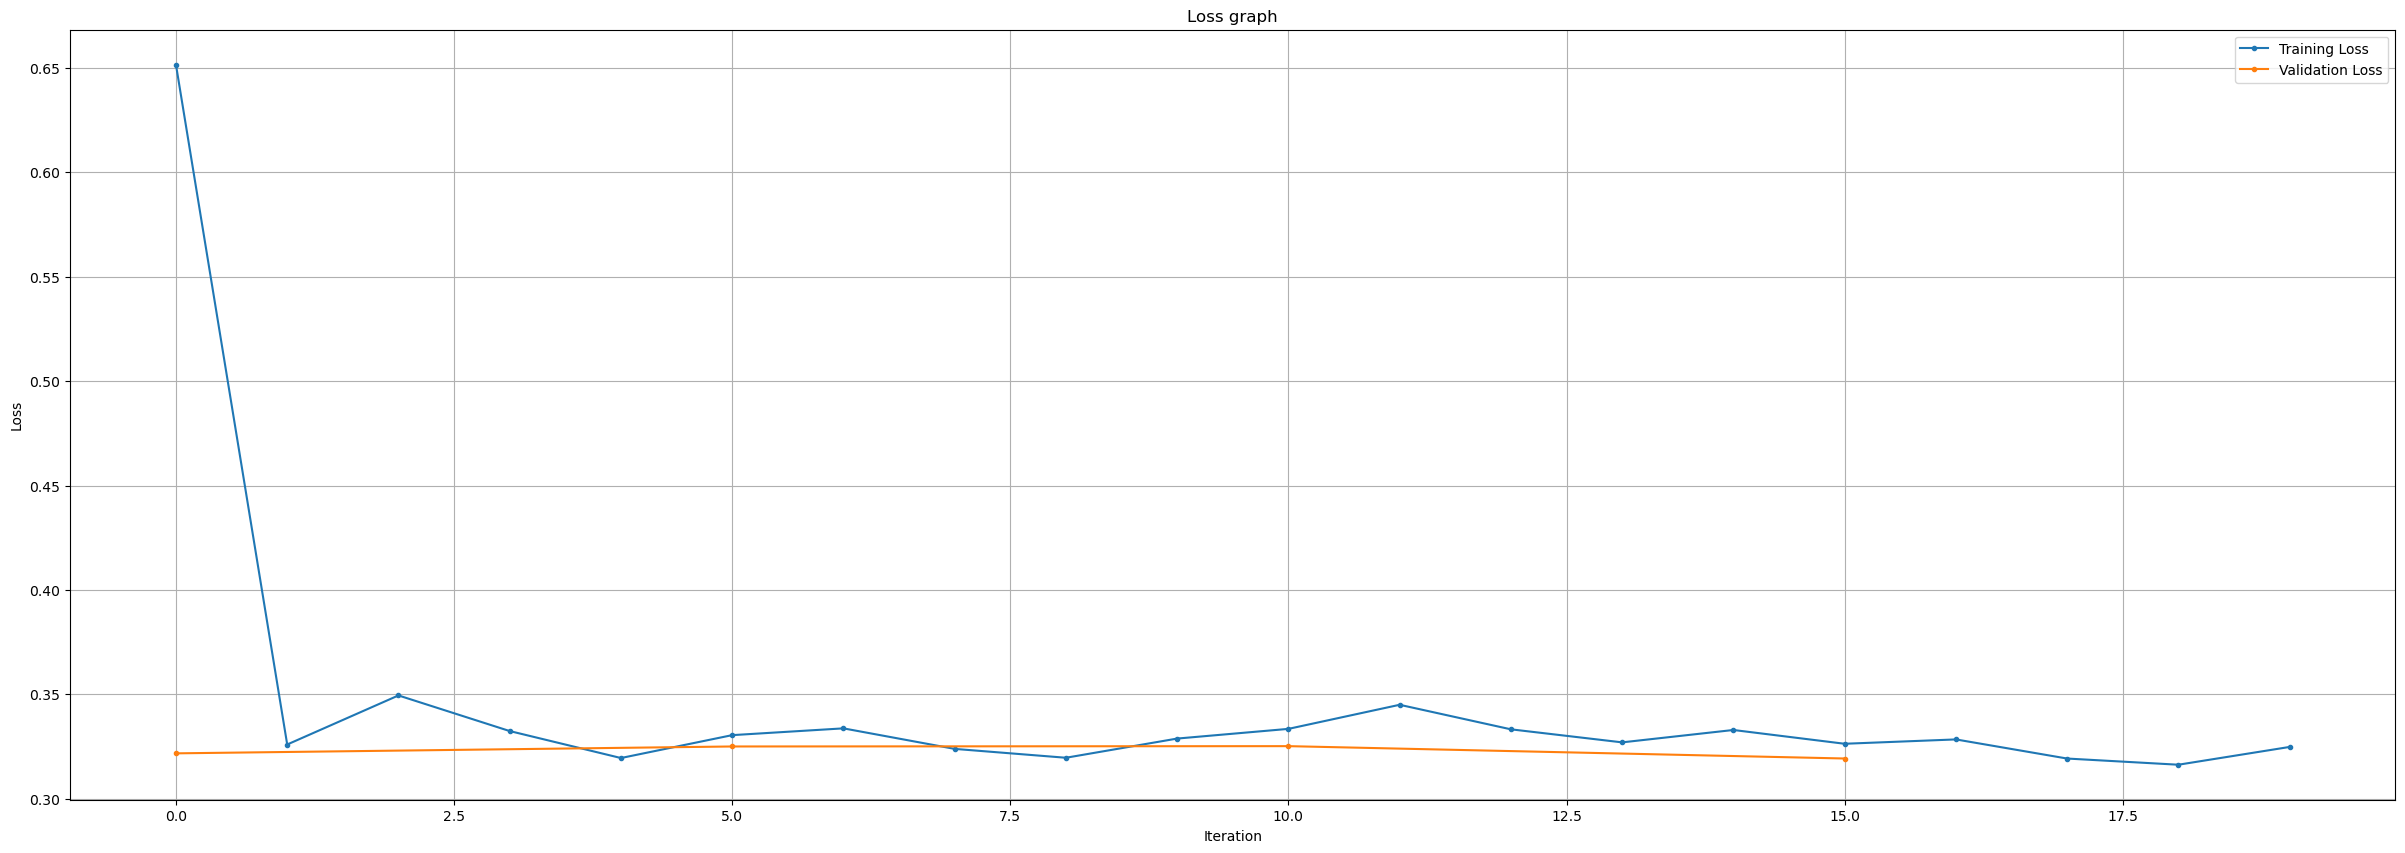

21 epoch now
22 epoch now


KeyboardInterrupt: 

In [10]:
st_model.Train(
    train_X = train_X,
    train_y = train_y,
    val_X = val_X,
    val_y = val_y,
    num_of_epochs = 30,
    learning_rate = 1e-1,
    batch_size = 10,
    loss_func = torch.nn.CrossEntropyLoss(), 
    use_reg = False,
    reg_level = 2,
    optimizer = 1,
    is_sched_use = True,
    scheduler_freq = 5,
    scheduler_gamma = 0.5,
    val_every = 5,
    show_every = 5,
)

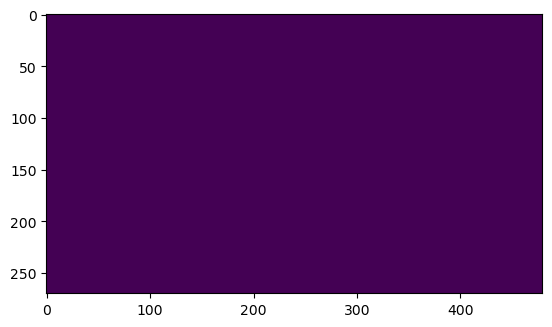

In [11]:
pred = show_answer(train_X[31],
                   st_model)